In [ ]:
import torch
import matplotlib.pyplot as plt
import sys
sys.path.insert(0,'../data_utils')
from tensor_support import remove_diagonal, add_diagonal
from Sample import Sample
from OrigamiTransform import OrigamiTransform
origami_transform = OrigamiTransform()

#### Load a sample to play with 

In [ ]:
def load_dist_maps(filepath,map_location='cuda' if torch.cuda.is_available() else 'cpu'):

    try:
        data = torch.load(filepath,map_location=map_location)
    except:
        data = pd.read_pickle(filepath).unflatten()

        if type(data) != torch.Tensor:
            data = torch.tensor(data)
            
        data = data.to(map_location)
    
    if len(data.shape) == 2:
        data = data.unsqueeze(0)
    if len(data.shape) == 3:
        if data.shape[0] > 2: # Batch size is in the second channel
            data = data.unsqueeze(1)
        else: # MOST LIKELY, batch size is 1 & this dimension corresponds to channels
            data = data.unsqueeze(0)
    assert data.shape[-2] == data.shape[-1], f"Expected square matrix in final two dimensions, but received shape {data.shape}"

    if data.shape[-3] == 2:
        data = origami_transform.inverse(data)
        data = remove_diagonal(data)
    
    sample = Sample(data = data) 
    sample.unnormalize_()
    
    return add_diagonal(sample.unflatten())
    

In [ ]:
dists = load_dist_maps('../../data/samples/origami_64_no_embed_reduction/sample_330_3.0_0.2_120_1.pt')

In [ ]:
def dist_to_coord(dists,device='cuda' if torch.cuda.is_available() else 'cpu'):
    '''
    Assumes self interactions are excluded from the map 
    '''

    if type(dists) != torch.Tensor:
        dists = torch.tensor(dists)
    return_dtype = dists.dtype
    return_device = dists.device
    dists = dists.to(dtype=torch.double,device=device)
        
    '''
    # For covenience...
    dists = self.batch[i,0,...]

    # Initialize the coordinates object 
    b,dt,dev = dists.shape[-1]+1, self.dtype, self.device
    coords = torch.empty(b,3,dtype=dt,device=dev)
    coords[:] = torch.nan
    '''
    coords = torch.empty_like(dists[...,:3])
    coords.fill_(torch.nan)
    
    # Place bead 0 at the origin 
    coords[...,0,:] = 0

    # Place bead 1 on the x axis 
    coords[...,1,0] = dists[...,0,1]
    coords[...,1,1:] = 0

    # Get other x coordinates
    #coords[2:,0] = (dists[0,1]**2 + dists[0,2:]**2 - dists[1,2:]**2) / (2*dists[0,1]**2)
    coords[...,2:,0] = ( 1 + (dists[...,0,2:]**2 - dists[...,1,2:]**2)/dists[...,0,1:2]**2 ) / 2

    # Place bead 2 in the xy plane with positive y 
    coords[...,2,1] = ( dists[...,0,2]**2 - coords[...,2,0]**2 ).sqrt()
    coords[...,2,2] = 0

    # Get other y coordinates
    coords[...,3:,1] = 1
    '''
    print(f': {.shape}')
    print(f': {.shape}')
    print(f': {.shape}')
    print(f': {.shape}')
    print(f': {.shape}')
    print(f': {.shape}')
    print(f': {.shape}')
    print(f': {.shape}')
    '''
    
    coords[...,3:,1]+= ( dists[...,0,3:]**2 - coords[...,3:,0]**2 - dists[...,2,3:]**2 + (coords[...,3:,0] - coords[...,2,0])**2 ) / (dists[...,0,2]**2 - coords[...,2,0]**2)
    #coords[...,3:,1]+= ( dists[...,0,3:]**2 - coords[...,3:,0]**2 - dists[...,2,3:]**2 + (coords[...,3:,0] - coords[...,2:3,0])**2 ) / (dists[...,0,2:3]**2 - coords[...,2:3,0]**2)
    coords[...,3:,1]/= 2

    # Give bead 3 a positive z value 
    coords[...,3,2] = ( dists[...,0,3]**2 - coords[...,3,:2].square().sum() ).sqrt()

    # Get other z coordinates
    coords[...,4:,2] = dists[...,0,4:]**2 - dists[...,3,4:]**2

    '''
    print(f'coords[...,4:,:2].shape: {coords[...,4:,:2].shape}')
    print(f'coords[...,3:4,:2]: {coords[...,3:4,:2].shape}')
    print(f'coords[...,4:,:2]: {coords[...,4:,:2].shape}')
    print(f'(coords[...,4:,:2] - coords[...,3:4,:2]).square().sum(-1): {(coords[...,4:,:2] - coords[...,3:4,:2]).square().sum(-1).shape}')
    print(f'coords[...,4:,:2].square().sum(-1): {coords[...,4:,:2].square().sum(-1).shape}')
    '''
    coords[...,4:,2]+= (coords[...,4:,:2] - coords[...,3,:2]).square().sum(1) - coords[...,4:,:2].square().sum(1)
    #coords[...,4:,2]+= (coords[...,4:,:2] - coords[...,3:4,:2]).square().sum(-1) - coords[...,4:,:2].square().sum(-1)
    coords[...,4:,2]/= coords[...,3:4,2]**2
    coords[...,4:,2]+= 1
    coords[...,4:,2]/= 2

    return coords.squeeze().to(device=return_device,dtype=return_dtype)

In [ ]:
def dist_to_coord(dists,device='cuda' if torch.cuda.is_available() else 'cpu'):
    '''
    Assumes self interactions are excluded from the map 
    '''

    '''
    # Ensure we have distances in their unnormalized form
    self.unnormalize_()

    # For covenience...
    dists = self.batch[i,0,...]
    '''
    # Initialize the coordinates object 
    b,dt,dev = dists.shape[-1]+1, dists.dtype,dists.device#self.dtype, self.device
    coords = torch.empty(b,3,dtype=dt,device=dev)
    coords[:] = torch.nan
    

    '''
    if type(dists) != torch.Tensor:
        dists = torch.tensor(dists)
    return_dtype = dists.dtype
    return_device = dists.device
    dists = dists.to(dtype=torch.double,device=device)

    #coords = torch.empty_like(dists[...,:3])
    coords = torch.empty(
        *dists.shape[:-2],dists.shape[-2]+1,3,
        dtype=torch.double,
        device=device
    )
    coords.fill_(torch.nan)
    '''

    # Place bead 0 at the origin 
    coords[0,:] = 0

    # Place bead 1 on the x axis 
    coords[1,0] = dists[0,0]
    coords[1,1:] = 0

    # Get other x coordinates
    #coords[2:,0] = (dists[0,1]**2 + dists[0,2:]**2 - dists[1,2:]**2) / (2*dists[0,1]**2)
    coords[2:,0] = ( 1 + (dists[0,1:]**2 - dists[1,1:]**2)/dists[0,0]**2 ) / 2

    # Place bead 2 in the xy plane with positive y 
    coords[2,1] = ( dists[0,1]**2 - coords[2,0]**2 ).sqrt()
    coords[2,2] = 0

    # Get other y coordinates
    coords[3:,1] = 1
    coords[3:,1]+= ( dists[0,2:]**2 - coords[3:,0]**2 - dists[2,2:]**2 + (coords[3:,0] - coords[2,0])**2 ) / (dists[0,1]**2 - coords[2,0]**2)
    coords[3:,1]/= 2

    # Give bead 3 a positive z value 
    coords[3,2] = ( dists[0,2]**2 - coords[3,:2].square().sum() ).sqrt()

    # Get other z coordinates
    coords[4:,2] = dists[0,3:]**2 - dists[3,3:]**2
    coords[4:,2]+= (coords[4:,:2] - coords[3,:2]).square().sum(1) - coords[4:,:2].square().sum(1)
    coords[4:,2]/= coords[3,2]**2
    coords[4:,2]+= 1
    coords[4:,2]/= 2

    return coords

In [6]:
def project_x_onto_y(x_dist_from_origin,dist_between_x_and_y,y_coords):
    '''
    Compute ( (x\dot y)/||y||^2 ) \vec{y} 
    '''

    y_dist_from_origin_squared = y_coords.square().sum(-1,keepdim=True)

    coefficients = .5*(x_dist_from_origin**2 - dist_between_x_and_y**2) / y_dist_from_origin_squared + .5
    coefficients = coefficients.transpose(-1,-2)
    return coefficients * y_coords
    

def vector_project_x_onto_y(x,y):
    return y * ( (x*y).sum(-1,keepdim=True) / y.square().sum(-1,keepdim=True) )

'''
def fetch_dim(index_selections,tensor,dim):
    index_selections = index_selections.flatten()
    while len(index_selections.shape) < len(tensor.shape):
        if len(index_selections.shape) < dim:
            index_selections = index_selections.unsqueeze(0)
        else:
            index_selections = index_selections.unsqueeze(-1)

    index_selections = index_selections.repeat(*tensor.shape[:dim],1,*tensor.shape[dim+1:])

    return tensor.gather(dim,index_selections)
'''
def my_mask(tensor,indices):

    # Because I treat the last dimension as a vector that should always stay together...
    indices = indices.unsqueeze(-1) 
    indices = indices.expand(*torch.ones(len(indices.shape)-1,dtype=int),tensor.shape[-1])
    
    return tensor.gather(-1,indices)
    

def cumulative_projection(known_coords,dists_from_coords):
    '''
    Origin should be passed as the first dimension
    '''

    if len(known_coords.shape) == 1:
        known_coords = known_coords.unsqueeze(0)
    if len(dists_from_coords.shape) == 1:
        dists_from_coords = dists_from_coords.unsqueeze(0)

    return_dtype = known_coords.dtype
    known_coords = known_coords.double()
    dists_from_coords = dists_from_coords.double()

    assert (known_coords.shape[:-1] == dists_from_coords.shape[:-1]).all(), "Size of known coords and distances from them don't match!"

    if known_coords.shape[-2] == 1:
        return dists_from_coords # The entire vector must still be accounted for, as we only have the origin

    cum_proj = None
    x_dist_from_origin = dists_from_coords[...,:1,:]
    for i in range(1,known_coords.shape[-2]):
        
        y_coords = known_coords[...,i:i+1,:]
        dist_between_x_and_y = dists_from_coords[...,i:i+1,:]

        proj = project_x_onto_y(x_dist_from_origin,dist_between_x_and_y,y_coords)

        if cum_proj is None:
            cum_proj = proj
        else:
            proj-= vector_project_x_onto_y(proj,cum_proj)
            cum_proj+= proj

    return cum_proj.to(return_dtype)

def perpendicular_component_magnitude(dist_from_origin,coords):
    out = dist_from_origin**2 - coords.square().sum(-1).unsqueeze(-2)
    out[out<0] = 0 # Correct for occasional numerical errors
    return out.sqrt()
    return (dist_from_origin**2 - coords.square().sum(-1).unsqueeze(-2)).sqrt()

def dists_to_coords(dists,device='cuda' if torch.cuda.is_available() else 'cpu',num_dimensions=3):

    # Use high-precision values throughout calculation, but return same dtype as provided
    # Same for device
    return_dtype = dists.dtype
    return_device = dists.device
    dists = dists.double().to(device)

    # Initialize the object to hold coordinates
    coords = torch.zeros_like(dists[...,:num_dimensions])

    # Set the first bead at the origin 
    dist_from_origin = dists[...,:1,:]
    d2 = dist_from_origin[...,1:].clone()
    for i in range(num_dimensions):

        # How much of each vector is normal to existing dimensions? 
        perp_remaining = perpendicular_component_magnitude(dist_from_origin,coords)
        print(perp_remaining)

        # Choose the median component in that direction as the new dimension to minimize numerical issues.
        # Using too small of a value leads to issues with division during projection. 
        # Using the largest value can lead to issues if the NN predicted a non-physical conformation. 
        new_dim_vals,new_dim_idx = perp_remaining.max(-1)

        # Place the bead with the median perpendicular component onto the current axis of interest
        coords[...,i].scatter_(-1,new_dim_idx,new_dim_vals)

        # Get the coordinates corresponding to this new dimension
        new_dim_idx = new_dim_idx.unsqueeze(-1).expand(*torch.ones(new_dim_idx.ndim,dtype=int),num_dimensions)
        new_reference_coords = coords.gather(-2,new_dim_idx)

        # Get the distance between other vectors and this vector so we can perform the projection
        new_dim_idx = new_dim_idx[...,:1].expand(*torch.ones(new_dim_idx.ndim-1,dtype=int),dists.shape[-1])
        dist_between_x_and_y = dists.gather(-2,new_dim_idx)

        # Project all other vectors onto this vector. 
        # Don't compute the projection in the origin section to avoid NaN results in that location
        proj = project_x_onto_y(
            dist_from_origin[...,1:],
            dist_between_x_and_y[...,1:],
            new_reference_coords
        )
        #print(proj)

        # Subtract the portion of this projection that overlaps with the vector components already accounted for
        if i > 0:
            proj-= vector_project_x_onto_y(proj,coords[...,1:,:])
        #    #proj-= vector_project_x_onto_y(coords[...,1:,:],proj)
        #print(proj)

        # Update the coordinates based on the component we have now solved
        coords[...,1:,:]+= proj
        print(coords)

        d2 = (d2**2 - proj.square().sum(-1)).sqrt()
        print(d2)

    return coords.to(dtype=return_dtype,device=return_device)

##########################
# ANOTHER ATTEMPT
##########################
def dists_to_coords(dists,device='cuda' if torch.cuda.is_available() else 'cpu',num_dimensions=3):

    # Use high-precision values throughout calculation, but return same dtype as provided
    # Same for device
    return_dtype = dists.dtype
    return_device = dists.device
    dists = dists.double().to(device)

    # Initialize the object to hold coordinates
    coords = torch.zeros_like(dists[...,:num_dimensions])

    # Set the first bead at the origin 
    dist_from_origin = dists[...,:1,:]
    perp_remaining = dist_from_origin**2
    prior_vectors = []
    for i in range(num_dimensions):

        # How much of each vector is normal to existing dimensions? 
        #perp_remaining = perpendicular_component_magnitude(dist_from_origin,coords)
        #print(perp_remaining)

        # Choose the median component in that direction as the new dimension to minimize numerical issues.
        # Using too small of a value leads to issues with division during projection. 
        # Using the largest value can lead to issues if the NN predicted a non-physical conformation. 
        new_dim_vals,new_dim_idx = perp_remaining.max(-1)
        new_dim_vals.sqrt_() # sqrt b/c perp_remaining tracks (unaccounted component)**2

        # Place the bead with the median perpendicular component onto the current axis of interest
        coords[...,i].scatter_(-1,new_dim_idx,new_dim_vals) 

        # Get the coordinates corresponding to this new dimension
        #new_dim_idx = new_dim_idx.unsqueeze(-1).expand(*torch.ones(new_dim_idx.ndim,dtype=int),num_dimensions)
        new_dim_idx = new_dim_idx.unsqueeze(-1).expand(*new_dim_idx.shape,num_dimensions)
        new_reference_coords = coords.gather(-2,new_dim_idx)

        # Get the distance between other vectors and this vector so we can perform the projection
        new_dim_idx = new_dim_idx[...,:1]
        new_dim_idx = new_dim_idx.expand(*new_dim_idx.shape[:-1],dists.shape[-1])
        #new_dim_idx = new_dim_idx[...,:1].expand(*torch.ones(new_dim_idx.ndim-1,dtype=int),dists.shape[-1])
        dist_between_x_and_y = dists.gather(-2,new_dim_idx)

        # Project all other vectors onto this vector. 
        # Don't compute the projection in the origin section to avoid NaN results in that location
        proj = project_x_onto_y(
            dist_from_origin[...,1:],
            dist_between_x_and_y[...,1:],
            new_reference_coords
        )
        #print(proj)

        # Subtract the portion of this projection that overlaps with the vector components already accounted for
        #proj1 = proj.clone()
        #if i > 0:
        #    proj-= vector_project_x_onto_y(proj,coords[...,1:,:])
            #proj-= vector_project_x_onto_y(coords[...,1:,:],proj)
        #print(proj)

        #print(dist_from_origin[...,1:] - proj.square().sum(-1).unsqueeze(-2))
        #print(proj1.square().sum(-1) - proj.square().sum(-1))
        #proj_magnitude = proj.square().sum(-1,keepdim=True)
        proj1 = proj.clone()
        for vec in prior_vectors:
            proj-= vector_project_x_onto_y(proj,vec)
            #new_reference_coords-= vector_project_x_onto_y(new_reference_coords,vec)
        #prior_vectors.append(new_reference_coords)#/new_reference_coords.square().sum(-1,keepdim=True).sqrt())
        # Must rescale vector length! Knowing orthognal & projection components, we have two legs of a right triangle
        a_squared = proj1.square().sum(-1,keepdim=True)
        b_squared = (proj1 - proj).square().sum(-1,keepdim=True)
        c = (a_squared + b_squared).sqrt()
        proj/= proj.square().sum(-1,keepdim=True).sqrt()
        proj*= c

        # Update the coordinates based on the component we have now solved
        coords[...,1:,:]+= proj
        perp_remaining[...,1:]-= proj.square().sum(-1).unsqueeze(-2)
        print(perp_remaining)
        
    
    return coords.to(dtype=return_dtype,device=return_device)


##########################
# ANOTHER ATTEMPT: Use inversion! 
##########################
def x_dot_y(x_norm,y_norm,x_minus_y_norm):
    # From known vector norms
    y_norm = y_norm.expand_as(x_norm)
    return (x_norm**2 + y_norm**2 - x_minus_y_norm**2) / 2

def vector_dot(vec1,vec2,dim=-1):
    return (vec1*vec2).sum(-1)

def dists_to_coords(dists,device='cuda' if torch.cuda.is_available() else 'cpu',num_dimensions=3):

    # Use high-precision values throughout calculation, but return same dtype as provided
    # Same for device
    return_dtype = dists.dtype
    return_device = dists.device
    dists = dists.double().to(device)

    # Initialize the object to hold coordinates
    #coords = torch.zeros_like(dists[...,:num_dimensions])
    dot_products = torch.zeros_like(dists[...,:num_dimensions])
    reference_vectors = dot_products[...,:num_dimensions,:].clone()

    # For convenience in indexing
    single_coord_shape = dot_products[...,:1,:].shape
    single_dist_shape = dists[...,:1,:].shape
    
    '''
    S1 = S.T
    
    v = torch.tensor([[2.],[1]])
    
    torch.linalg.solve(
        S.T,
        torch.tensor(
            [
                [(s1*v).sum()],
                [(s2*v).sum()]
            ]
        )
    )
    '''

    
    # Set the first bead at the origin. Then the distance from that bead is that vector's L2 norm
    vector_norms = dists[...,:1,:]
    selection_metric = vector_norms**2
    reference_norms = []
    reference_difference_norms = []
    for i in range(num_dimensions):

        # Selection metric ~approximately~ tracks the proportion of the vectors not yet accounted for, indicating
        # how far out of the span of already-selected vectors they are. 
        # Choose the vector with the median component in that direction as the new dimension to minimize numerical issues.
        # Using too small of a value leads to issues with division during projection. 
        # Using the largest value can lead to issues if the NN predicted a non-physical conformation. 
        new_dim_idx = selection_metric.median(-1,keepdim=True)[-1]

        # Get the dot product between this vector and all others
        y_norm = vector_norms.gather(-1,new_dim_idx)
        x_minus_y_norm = dists.gather(-1,new_dim_idx.expand(*new_dim_idx.shape[:-1],dists.shape[-1]-1))
        dot_products[...,1:,i:i+1] = x_dot_y(
            vector_norms[...,1:],
            y_norm,
            x_minus_y_norm
        ).transpose(-2,-1)

        rv = reference_vectors # ease of notation
        if i == 0:
            # Fully aline the vector with the positive x-axis
            rv[...,i:i+1,:1] = y_norm
        else:
            for j in range(i):
                # basis vector norm & distance from reference norm
                bvn = reference_norms[j]
                drn = reference_difference_norms[j].gather(-1,new_dim_idx)
                #print(f'Target: {rv[...,i,j:j+1].shape}')
                #print(f'dot: {x_dot_y(y_norm,bvn,drn).shape}')
                rv[...,i:i+1,j:j+1] = x_dot_y(y_norm,bvn,drn)

                if j > 0:
                    rv[...,i,j]-= vector_dot(
                        rv[...,i,:j],     # v_0, ..., v_{j-1} for vector currently being solved
                        rv[...,j-1,:j]    # v_0, ..., v_{j-1} for prior reference vector
                    )
                rv[...,i,j]/= rv[...,j,j]

            # Vector component lying orthogonal to already-accounted-for dimensions
            #print(f'y_norm: {y_norm.shape}')
            #print(f'rv: {rv[...,i:i+1,:i].square().sum(-1,keepdim=True).shape}')
            rv[...,i:i+1,i:i+1] = (y_norm.square() - rv[...,i:i+1,:i].square().sum(-1,keepdim=True)).sqrt() 
        # Save the information for future loop iterations
        reference_norms.append(y_norm)
        reference_difference_norms.append(x_minus_y_norm)

        selection_metric[...,1:]-= (dot_products[...,1:,i:i+1] / y_norm**2 * rv[...,i:i+1,:]).sum(-1).unsqueeze(-2)

    print(reference_vectors.shape)
    print(dot_products.shape)
    coords = torch.linalg.solve(reference_vectors,dot_products.transpose(-2,-1)).transpose(-2,-1)
    
    return coords.to(dtype=return_dtype,device=return_device)

##########################
# ANOTHER ATTEMPT: No inversion, more similar to original approach but better generalized
##########################
def x_dot_y(x_norm,y_norm,x_minus_y_norm):
    # From known vector norms
    y_norm = y_norm.expand_as(x_norm)
    return (x_norm**2 + y_norm**2 - x_minus_y_norm**2) / 2

def vector_dot(vec1,vec2,dim=-1):
    return (vec1*vec2).sum(-1)

def select_new_indices(dists,dist_from_origin,coords):
    dist_not_accounted_for = (dist_from_origin.square() - coords.square().sum(-1,keepdim=True).square()).sqrt()

    # Select maximum value to minimize numerical errors with division on this value later
    return dist_not_accounted_for.max(-2,keepdim=True)
    
def compute_new_dimension(coords,dists,reference_indices):
    # Everything operates in-place
    if len(reference_indices) == 0:
        # Set a central bead at the origin
        idx = torch.tensor(dists.shape[-1]//2).expand_as(dists[...,:1])
        reference_indices.append(idx)

    ri = reference_indices # ease of notation
    x_norm = dists.gather(-1,ri[0]) # Distance from origin

    coord_value, idx = select_new_indices(x_norm,coords)
    dim = len(ri) - 1
    #coords[...,dim:dim+1].scatter_(-2,idx,coord_value)
    y_norm = x_norm.gather(-2,idx) # Distance from origin for new reference bead
    x_minus_y_norm = dists.gather(-1,idx) # Distance between all beads and the new reference bead
    
    new_coord_values = x_dot_y(x_norm,y_norm,x_minus_y_norm)
    if dim > 0:
        selected_coord_prior_values = coords[...,:dim].gather(-2,idx).expand_as(coords[...,:dim])
        new_coord_values-= (selected_coord_prior_values * coords[...,:dim]).sum(-1,keepdim=True) # Dot product
    new_coord_values/= coord_value
    coords[...,dim:dim+1] = new_coord_values

    ri.append(idx)
    

def dists_to_coords(dists,device='cuda' if torch.cuda.is_available() else 'cpu',num_dimensions=3):

    # Use high-precision values throughout calculation, but return same dtype as provided
    # Same for device
    return_dtype = dists.dtype
    return_device = dists.device
    dists = dists.double().to(device)

    # Initialize the object to hold coordinates
    #coords = torch.zeros_like(dists[...,:num_dimensions])
    coords = torch.zeros_like(dists[...,:num_dimensions])
    reference_vectors = dot_products[...,:num_dimensions,:].clone()

    # For convenience in indexing
    single_coord_shape = dot_products[...,:1,:].shape
    single_dist_shape = dists[...,:1,:].shape
    
    # Set the first bead at the origin. Then the distance from that bead is that vector's L2 norm
    vector_norms = dists[...,:1,:]
    selection_metric = vector_norms**2
    reference_norms = []
    reference_difference_norms = []
    for i in range(num_dimensions):

        # Selection metric ~approximately~ tracks the proportion of the vectors not yet accounted for, indicating
        # how far out of the span of already-selected vectors they are. 
        # Choose the vector with the median component in that direction as the new dimension to minimize numerical issues.
        # Using too small of a value leads to issues with division during projection. 
        # Using the largest value can lead to issues if the NN predicted a non-physical conformation. 
        new_dim_idx = selection_metric.median(-1,keepdim=True)[-1]

        # Get the dot product between this vector and all others
        y_norm = vector_norms.gather(-1,new_dim_idx)
        x_minus_y_norm = dists.gather(-1,new_dim_idx.expand(*new_dim_idx.shape[:-1],dists.shape[-1]-1))
        dot_products[...,1:,i:i+1] = x_dot_y(
            vector_norms[...,1:],
            y_norm,
            x_minus_y_norm
        ).transpose(-2,-1)

        rv = reference_vectors # ease of notation
        if i == 0:
            # Fully aline the vector with the positive x-axis
            rv[...,i:i+1,:1] = y_norm
        else:
            for j in range(i):
                # basis vector norm & distance from reference norm
                bvn = reference_norms[j]
                drn = reference_difference_norms[j].gather(-1,new_dim_idx)
                #print(f'Target: {rv[...,i,j:j+1].shape}')
                #print(f'dot: {x_dot_y(y_norm,bvn,drn).shape}')
                rv[...,i:i+1,j:j+1] = x_dot_y(y_norm,bvn,drn)

                if j > 0:
                    rv[...,i,j]-= vector_dot(
                        rv[...,i,:j],     # v_0, ..., v_{j-1} for vector currently being solved
                        rv[...,j-1,:j]    # v_0, ..., v_{j-1} for prior reference vector
                    )
                rv[...,i,j]/= rv[...,j,j]

            # Vector component lying orthogonal to already-accounted-for dimensions
            #print(f'y_norm: {y_norm.shape}')
            #print(f'rv: {rv[...,i:i+1,:i].square().sum(-1,keepdim=True).shape}')
            rv[...,i:i+1,i:i+1] = (y_norm.square() - rv[...,i:i+1,:i].square().sum(-1,keepdim=True)).sqrt() 
        # Save the information for future loop iterations
        reference_norms.append(y_norm)
        reference_difference_norms.append(x_minus_y_norm)

        selection_metric[...,1:]-= (dot_products[...,1:,i:i+1] / y_norm**2 * rv[...,i:i+1,:]).sum(-1).unsqueeze(-2)

    print(reference_vectors.shape)
    print(dot_products.shape)
    coords = torch.linalg.solve(reference_vectors,dot_products.transpose(-2,-1)).transpose(-2,-1)
    
    return coords.to(dtype=return_dtype,device=return_device)
        
        
        

    
    
    

In [24]:
def x_dot_y(x_norm,y_norm,x_minus_y_norm):
    # From known vector norms
    y_norm = y_norm.expand_as(x_norm)
    return (x_norm**2 + y_norm**2 - x_minus_y_norm**2) / 2

def select_new_indices(dist_from_origin,coords):
    dist_not_accounted_for = (dist_from_origin.square() - coords.square().sum(-1,keepdim=True))
    dist_not_accounted_for[torch.isclose(dist_not_accounted_for,torch.zeros_like(dist_not_accounted_for))] = 0
    dist_not_accounted_for.sqrt_()
    # Select maximum value to minimize numerical errors with division on this value later
    return dist_not_accounted_for.max(-2,keepdim=True)
    
def compute_new_dimension(coords,dists,reference_indices):
    # Everything operates in-place
    if len(reference_indices) == 0:
        # Set a central bead at the origin
        idx = torch.tensor(dists.shape[-1]//2).expand_as(dists[...,:1])
        reference_indices.append(idx)

    ri = reference_indices # ease of notation
    x_norm = dists.gather(-1,ri[0]) # Distance from origin
    
    coord_value, idx = select_new_indices(x_norm,coords)
    idx = idx.expand_as(dists[...,:1])
    dim = len(ri) - 1
    y_norm = x_norm.gather(-2,idx) # Distance from origin for new reference bead
    x_minus_y_norm = dists.gather(-1,idx) # Distance between all beads and the new reference bead
    
    new_coord_values = x_dot_y(x_norm,y_norm,x_minus_y_norm)
    #print(new_coord_values)
    if dim > 0:
        selected_coord_prior_values = coords[...,:dim].gather(-2,idx.expand_as(coords[...,:dim]))
        new_coord_values-= (selected_coord_prior_values * coords[...,:dim]).sum(-1,keepdim=True) # Dot product
    new_coord_values/= coord_value
    coords[...,dim:dim+1] = new_coord_values
    
    ri.append(idx)

def dists_to_coords(dists,device=None,num_dimensions=3):

    # Use high-precision values throughout calculation, but return same dtype as provided
    # Same for device
    return_dtype = dists.dtype
    return_device = dists.device
    if device is None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
    dists = dists.double().to(device)

    # Initialize the object to hold coordinates
    coords = torch.zeros_like(dists[...,:num_dimensions])

    # Keep track of reference indices
    reference_indices = []

    for _ in range(num_dimensions): 
        compute_new_dimension(coords,dists,reference_indices)

    return coords.to(dtype=return_dtype,device=return_device)
    

    
    

In [25]:
def generate_sample(nbeads,nsamples):

    sample = torch.empty(nsamples,nbeads,3)
    sample[:,0,:] = 0 
    for i in range(1,nbeads):
        step = torch.randn_like(sample[:,0,:])
        step/= step.square().sum(-1,keepdim=True).sqrt()
        sample[:,i,:] = sample[:,i-1,:] + step

    sample = sample.squeeze()
    if len(sample.shape) == 1:
        sample = sample.unsqueeze(0)
    
    return sample
    

Time 1: 0.002108335494995117 seconds
Time 2: 0.007660627365112305 seconds
Time 3: 0.002444028854370117 seconds
Time 4: 18.105817317962646 seconds


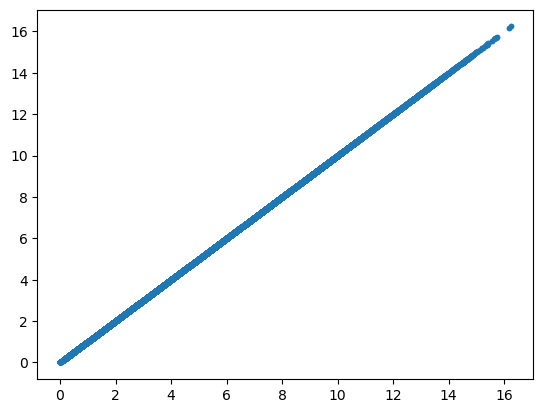

In [30]:
import time
a = generate_sample(64,100).double()
t = time.time()
dist1 = torch.cdist(a,a)
t-= time.time()
print(f'Time 1: {-t} seconds')

t = time.time()
b = dists_to_coords(dist1)
t-= time.time()
print(f'Time 2: {-t} seconds')

t = time.time()
dist2 = torch.cdist(b,b)
t-= time.time()
print(f'Time 3: {-t} seconds')

t = time.time()
plt.plot(dist1.flatten().cpu(),dist2.flatten().cpu(),'.')
t-= time.time()
print(f'Time 4: {-t} seconds')

In [97]:
#a = torch.rand(10,3).double()
a = generate_sample(10,3)
dist1 = torch.cdist(a,a)
b = dists_to_coords(dist1)
dist2 = torch.cdist(b,b)
plt.plot(dist1.flatten().cpu(),dist2.flatten().cpu(),'.')

RuntimeError: index 9 is out of bounds for dimension 2 with size 9

In [15]:
v = torch.tensor([2,3,4]).double()
'''
x = torch.tensor([1.,0,0])
y = torch.tensor([0.,1,0])
z = torch.tensor([0.,0,1])
w = vector_project_x_onto_y(v,x) + vector_project_x_onto_y(v,y) + vector_project_x_onto_y(v,z)
w
'''
x = torch.tensor([1.,0,0]).double()
y = torch.tensor([1.,1,0]).double()
z = torch.tensor([1.,1,1]).double()
w = torch.zeros(3).double()
basis = [x,y,z]
ortho_basis = []
for i,vec in enumerate(basis):
    proj = vector_project_x_onto_y(v,vec)
    #print(proj)
    proj1 = proj.clone()
    #if i>0:
    #    proj-= vector_project_x_onto_y(proj,w)
    #proj1 = proj.clone()
    #for vec1 in basis[:i]:
    #    proj-= vector_project_x_onto_y(proj,vec1)
    #    vec-= vector_project_x_onto_y(vec,vec1)
    for vec1 in ortho_basis:
        proj-= vector_project_x_onto_y(proj,vec1)
        vec-= vector_project_x_onto_y(vec,vec1)
    ortho_basis.append(vec/vec.square().sum(-1,keepdim=True).sqrt())
    
    a_squared = proj1.square().sum(-1,keepdim=True)
    b_squared = (proj1-proj).square().sum(-1,keepdim=True)
    proj*= (a_squared+b_squared).sqrt() / a_squared.sqrt()
    w+= proj
    print(w)
#w

tensor([2., 0., 0.], dtype=torch.float64)
tensor([2.0000, 3.0619, 0.0000], dtype=torch.float64)
tensor([2.0000, 3.0619, 3.8730], dtype=torch.float64)


In [16]:
def projection_length(x_dist_from_origin,dist_between_x_and_y,y_coords):
    '''
    Compute ( (x\dot y)/||y||^2 ) \vec{y} 
    '''

    y_dist_from_origin_squared = y_coords.square().sum(-1,keepdim=True)

    coefficients = .5*(x_dist_from_origin**2 - dist_between_x_and_y**2) / y_dist_from_origin_squared + .5
    coefficients = coefficients.transpose(-1,-2)
    return coefficients

a = torch.empty(2,3,4)
for k in range(4):
    a[...,k] = k
a = a.unsqueeze(-1).expand(*a.shape,5)
a[...,1,:]
idx = torch.randint(0,3,a[:,:1,:].shape)
b = a.gather(-2,idx)
b[:] = -1
a

In [20]:
a = torch.rand(10,10,1)
a.expand(...,10).shape

TypeError: expand(): argument 'size' (position 1) must be tuple of ints, but found element of type ellipsis at pos 0

In [ ]:
x = torch.rand(3,10,3)
y = torch.rand(3,10,3)
p = vector_project_x_onto_y(x,y)
#z = vector_project_x_onto_y(p,y)
#torch.allclose(p,z)
z = x - p
(z*y).sum(-1)

In [ ]:
torch.rand(10,10,10).median(-1)[-1].shape

In [99]:
def test(a):
    a.append('a')
a = []
test(a)
a

['a']

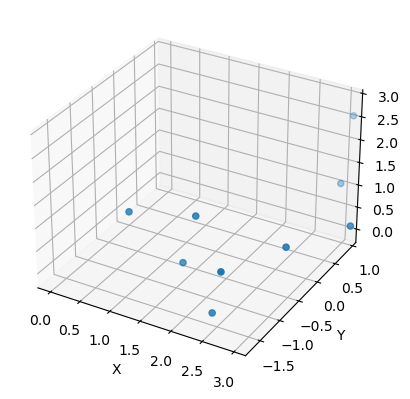

In [183]:
ax = plt.figure().add_subplot(projection='3d')

# Plot a sin curve using the x and y axes.
x = a[:,0]
y = a[:,1]
z = a[:,2]
ax.scatter(x, y, zs=z, zdir='y', label='points in (x, z)')

# Make legend, set axes limits and labels
'''
ax.legend()
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_zlim(0, 1)
'''
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Customize the view angle so it's easier to see that the scatter points lie
# on the plane y=0
#ax.view_init(elev=20., azim=-35, roll=0)

plt.show()

Text(0.5, 0, 'Z')

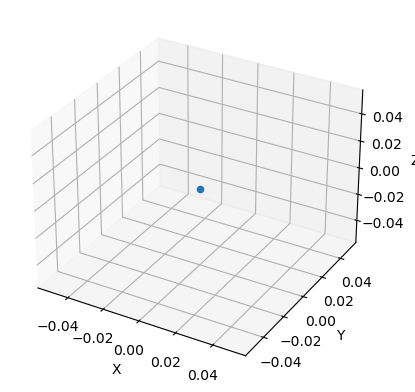

In [157]:
ax = plt.figure().add_subplot(projection='3d')

# Plot a sin curve using the x and y axes.
x = b[:,0].cpu()
y = b[:,1].cpu()
z = b[:,2].cpu()
ax.scatter(x, y, zs=z, zdir='y', label='points in (x, z)')

# Make legend, set axes limits and labels
'''
ax.legend()
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_zlim(0, 1)
'''
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Customize the view angle so it's easier to see that the scatter points lie
# on the plane y=0
#ax.view_init(elev=20., azim=-35, roll=0)

#plt.show()

In [158]:
torch.cdist(b,b)[range(1,10),range(9)]

tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan], device='cuda:0',
       dtype=torch.float64)

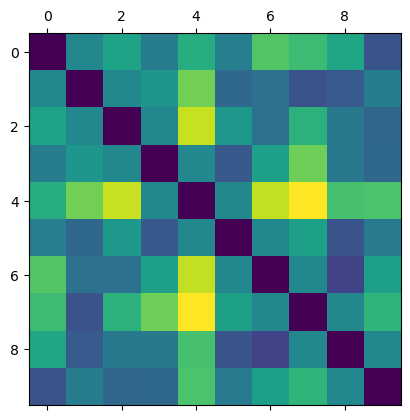

In [159]:
plt.matshow(dist1.cpu().numpy())

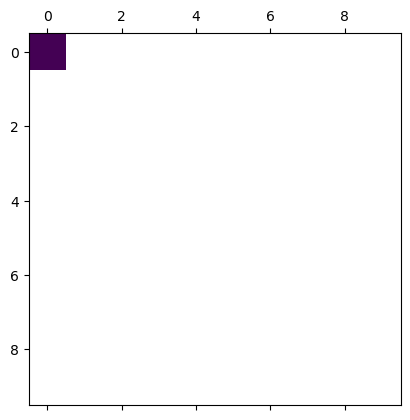

In [160]:
plt.matshow(dist2.cpu().numpy())

In [18]:
a = torch.rand(5,5,5)
b = torch.zeros_like(a).to(bool)
b[:,0,:] = True
c = a[b].reshape(5,1,5).expand_as(a)
a==c

tensor([[[ True,  True,  True,  True,  True],
         [False, False, False, False, False],
         [False, False, False, False, False],
         [False, False, False, False, False],
         [False, False, False, False, False]],

        [[ True,  True,  True,  True,  True],
         [False, False, False, False, False],
         [False, False, False, False, False],
         [False, False, False, False, False],
         [False, False, False, False, False]],

        [[ True,  True,  True,  True,  True],
         [False, False, False, False, False],
         [False, False, False, False, False],
         [False, False, False, False, False],
         [False, False, False, False, False]],

        [[ True,  True,  True,  True,  True],
         [False, False, False, False, False],
         [False, False, False, False, False],
         [False, False, False, False, False],
         [False, False, False, False, False]],

        [[ True,  True,  True,  True,  True],
         [False, False, Fa

In [142]:
b.gather(1,torch.zeros(5,1,5,dtype=int))#.shape

tensor([[[True, True, True, True, True]],

        [[True, True, True, True, True]],

        [[True, True, True, True, True]],

        [[True, True, True, True, True]],

        [[True, True, True, True, True]]])

In [145]:
b = a.shape
b[1] = 2
b

TypeError: 'torch.Size' object does not support item assignment

In [148]:
a.shape[:0]

torch.Size([])

In [151]:
torch.arange(10)[3::]

tensor([3, 4, 5, 6, 7, 8, 9])

In [153]:
torch.arange(5).repeat(2,1).shape

torch.Size([2, 5])

In [156]:
torch.rand(2,5,10).max(1)[1]

tensor([[4, 1, 1, 0, 0, 0, 4, 2, 2, 3],
        [0, 3, 3, 4, 1, 1, 0, 1, 4, 1]])

In [159]:
a = torch.zeros(5,5,5)
#a[:,3,:][:,1] = 1
a[...,0].scatter_(-1,torch.ones(5,5,dtype=int),torch.ones(5,5))

a

tensor([[[0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]]])

In [2]:
import torch
torch.rand(5,5).median(1)

torch.return_types.median(
values=tensor([0.1631, 0.5578, 0.7171, 0.6857, 0.4352]),
indices=tensor([2, 0, 4, 4, 2]))

In [4]:
torch.ones(5,5).ndim

2

In [182]:
s1 = [2.,1] # basis vectors
s2 = [1.,3]
v = [-1.,2] # Vector we're trying to solve

v = torch.tensor(v).unsqueeze(-1)
s1 = torch.tensor(s1).unsqueeze(-1)
s2 = torch.tensor(s2).unsqueeze(-1)
S = torch.cat([s1,s2],dim=1)
print(S)

overlap = S.T @ v#( (S.T @ v).flatten() / S.T.square().sum(-1).sqrt() ).unsqueeze(-1)

torch.linalg.solve(S.T,overlap)

tensor([[2., 1.],
        [1., 3.]])


tensor([[-1.],
        [ 2.]])

In [94]:
a = generate_sample(10,3)
S = torch.tensor([
    [1.,0,0],
    [1,1,0],
    [1,1,1]
])
b = torch.linalg.solve(S,S @ a.transpose(-2,-1)).transpose(-2,-1)

In [95]:
b-a

tensor([[[ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  2.9802e-08,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00, -5.9605e-08],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00, -1.1921e-07],
         [ 0.0000e+00,  0.0000e+00,  2.9802e-08],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  5.9605e-08,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  2.9802e-08],
         [ 0.0000e+00,  1.1921e-07,  0.0000e+00]],

        [[ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  2.9802e-08, -5.9605e-08],
         [ 0.0000e+00,  8.9407e-08,  5.9605e-08],
         [ 0.0000e+00,  2.9802e-08, -1.1921e-07],
         [ 0.0000e+00,  2.3842e-07,  1.7881e-07],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00, -1.1921e-07],
         [ 0.0000e+00, -2.3842e-07,  5.9605e-08]

In [3]:
import torch
a = torch.rand(5).cuda()

In [5]:
a.is_cuda

True

In [10]:
a.device.type

'cuda'

In [11]:
a.cuda(0)

tensor([0.8067, 0.4633, 0.7375, 0.7931, 0.1350], device='cuda:0')

In [15]:
if False or\
  True:
    print('ah')

ah


In [17]:
if True or (False and True):
    print('a')

a


In [22]:
if False\
or False or (1==1 and 2==2):
    print('a')

a


In [27]:
def test():
    if (False)\ '''asdf'''
    or  True:
        print('a')
test()

SyntaxError: unexpected character after line continuation character (2945408504.py, line 2)

In [37]:
a = torch.rand(5,5,5)
a.mean(tuple(range(1,a.ndim)))

tensor([0.5329, 0.5127, 0.4876, 0.5881, 0.4768])